# Introduction

In this notebook, we will try to find the underlying **relationships between the 14 coins** as suggested in the introductory notebook by the competition host. 
> We encourage participants to perform additional statistical analyses to have a stronger grasp on the dataset, including autocorrelation, time-series decomposition and stationarity tests. - [Tutorial to the G-Research Crypto Competition](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition)

Along the way, we intend to interpret our findings in the hope of providing some **domain knowledge** about the crypto scene (which is also going to include a few memes).

<img src="https://media.giphy.com/media/YkYt0FzMNPJkFnSQlf/giphy.gif" style="width: 800px;">

<a href="https://giphy.com/gifs/carlos-scam-bitconnect-YkYt0FzMNPJkFnSQlf">via GIPHY</a>

# Summary

- Correlation between coins highly varies over time
- Similarly to share prices, coin prices seem to follow a **random walk** pattern, which is difficult to predict
- Feature Engineering:
    - Time Features (e.g., `year`, `month`, `dayofweek`, etc.)
    - Log Return
    - Lag Features
    - RatioGang: Ratio between BTC and ETH

In [ ]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)

from datetime import datetime

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import warnings # Supress warnings
warnings.filterwarnings("ignore")

data_folder = "../input/g-research-crypto-forecasting/"

asset_details = pd.read_csv(data_folder + 'asset_details.csv', low_memory=False)
train = pd.read_csv(data_folder + 'train.csv', low_memory=False)
#supplemental_train = pd.read_csv(data_folder + 'supplemental_train.csv', low_memory=False)
#example_test = pd.read_csv(data_folder + 'example_test.csv', low_memory=False)
#example_sample_submission = pd.read_csv(data_folder + 'example_sample_submission.csv', low_memory=False)

rename_dict = {}
for a in asset_details['Asset_ID']:
    rename_dict[a] = asset_details[asset_details.Asset_ID == a].Asset_Name.values[0]

#display(asset_details)

# Preprocessing

For the following EDA, we will **resample the minute-wise crypto data to daily samples**. This reduces the amount of samples from 24,236,806 to 1,360. 

In [ ]:
# Convert timestamp
train['timestamp'] = train['timestamp'].astype('datetime64[s]')
#supplemental_train['timestamp'] = supplemental_train['timestamp'].astype('datetime64[s]')
#example_test['timestamp'] = example_test['timestamp'].astype('datetime64[s]')

#train['date'] = pd.DatetimeIndex(train['timestamp']).date
#supplemental_train['date'] = pd.DatetimeIndex(supplemental_train['timestamp']).date
#example_test['date'] = pd.DatetimeIndex(example_test['timestamp']).date

# Resample
train_daily = pd.DataFrame()

for asset_id in asset_details.Asset_ID:
    train_single = train[train.Asset_ID == asset_id].copy()

    train_single_new = train_single[['timestamp','Count']].resample('D', on='timestamp').sum()
    train_single_new['Open'] = train_single[['timestamp','Open']].resample('D', on='timestamp').first()['Open']
    train_single_new['High'] = train_single[['timestamp','High']].resample('D', on='timestamp').max()['High']
    train_single_new['Low'] = train_single[['timestamp','Low']].resample('D', on='timestamp').min()['Low']
    train_single_new['Close'] = train_single[['timestamp','Close']].resample('D', on='timestamp').last()['Close']
    train_single_new['Volume'] = train_single[['timestamp','Volume']].resample('D', on='timestamp').sum()['Volume']
    # train_single_new['VWAP']
    #train_single_new['Target'] = train_single[['timestamp','Target']].resample('D', on='timestamp').mean()['Target']
    train_single_new['Asset_ID'] = asset_id

    train_daily = train_daily.append(train_single_new.reset_index(drop=False))
train_daily = train_daily.sort_values(by = ['timestamp', 'Asset_ID']).reset_index(drop=True)

train_daily = train_daily.pivot(index='timestamp', columns='Asset_ID')[['Count', 'Open', 'High', 'Low', 'Close', 'Volume']]
train_daily = train_daily.reset_index(drop=False)

display(train_daily.head(10))

# Data Overview

Furthermore, we have samples from 2018-01-01 to 2021-09-21 for the majority of coins. For TRON, Stellar, Cardano, IOTA, Maker, and Dogecoin we have fewer data starting from later in 2018 or even later in 2019 in Dogecoin's case.

In [ ]:
# Visualize
fig = make_subplots(
    rows=len(asset_details.Asset_ID), cols=1,
    subplot_titles=(asset_details.Asset_Name)
)

for i, asset_id in enumerate(asset_details.Asset_ID):
    fig.append_trace(go.Candlestick(x=train_daily.timestamp, 
                                         open=train_daily[('Open', asset_id)], 
                                         high=train_daily[('High', asset_id)], 
                                         low=train_daily[('Low', asset_id)], 
                                         close=train_daily[('Close', asset_id)]),
                  row=i+1, col=1,
                    )

    fig.update_xaxes(range=[train_daily.timestamp.iloc[0], train_daily.timestamp.iloc[-1]], row=i+1, col=1)


fig.update_layout(xaxis_rangeslider_visible = False, 
                  xaxis2_rangeslider_visible = False, 
                  xaxis3_rangeslider_visible = False,
                  xaxis4_rangeslider_visible = False,
                  xaxis5_rangeslider_visible = False,
                  xaxis6_rangeslider_visible = False,
                  xaxis7_rangeslider_visible = False,
                  xaxis8_rangeslider_visible = False,
                  xaxis9_rangeslider_visible = False,
                  xaxis10_rangeslider_visible = False,
                  xaxis11_rangeslider_visible = False,
                  xaxis12_rangeslider_visible = False,
                  xaxis13_rangeslider_visible = False,
                  xaxis14_rangeslider_visible = False,
                  height=3000, width=800, 
                  #title_text="Subplots with Annotations"
                      margin = dict(
        l = 0,
        r = 0,
        b = 0,
        t = 30,
        pad = 0)
                 )
                 
fig.show()

## Feature Engineering: Time Features
Let's create some simple time features

In [ ]:
train_daily['year'] = pd.DatetimeIndex(train_daily['timestamp']).year
train_daily['quarter'] = pd.DatetimeIndex(train_daily['timestamp']).quarter
train_daily['month'] = pd.DatetimeIndex(train_daily['timestamp']).month
train_daily['weekofyear'] = pd.DatetimeIndex(train_daily['timestamp']).weekofyear
train_daily['dayofyear'] = pd.DatetimeIndex(train_daily['timestamp']).dayofyear
train_daily['weekday'] = pd.DatetimeIndex(train_daily['timestamp']).weekday

## Feature Engineering: Log Return

To make a time series stationary, you can try differencing it. In this case, we will use the log return instead as shown below.

In [ ]:
# define function to compute log returns
def log_return(series, periods=1):
    # Copied from https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition
    return np.log(series).diff(periods=periods)


for i, asset_id in enumerate(asset_details.Asset_ID):
    train_daily[('lret',  asset_id)] = log_return(train_daily[( 'Close',  asset_id)])

In [ ]:
assets_mini = [1, 6]
# Visualize
f, ax = plt.subplots(nrows=len(assets_mini), ncols=1, figsize=(12, 6))
for i, asset_id in enumerate(assets_mini):

    sns.lineplot(data=train_daily, x='timestamp', y = ( 'lret',  asset_id) , ax=ax[i]);
    ax[i].set_title(asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0])
    ax[i].set_xlim([train_daily.timestamp.iloc[0], train_daily.timestamp.iloc[-1]])
    ax[i].set_ylim([-0.6,0.6])
    ax[i].set_ylabel('Log Return')
plt.suptitle('Log Return\n')

plt.tight_layout()
plt.show()

## COVID-19 Impact

In the below plots for the log return, we can see a negative peak around March 2020. If we have a closer look at the log return of e.g. Bitcoin, we can see that this was the impact of the COVID-19 pandemic.

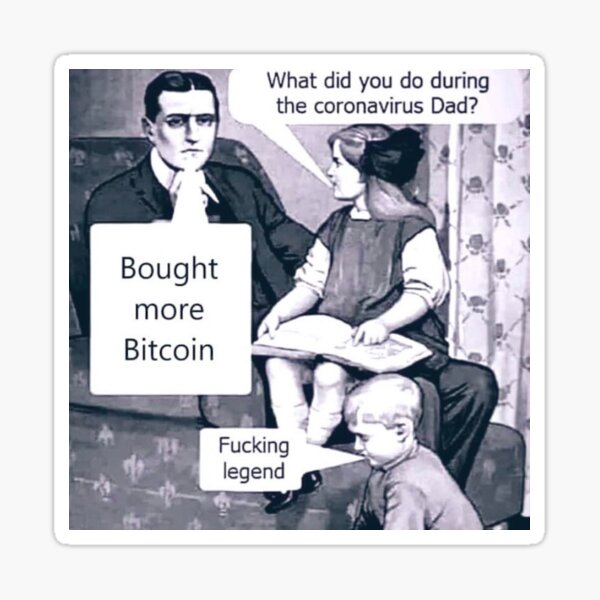

<a href="https://www.redbubble.com/de/i/sticker/Kaufte-mehr-Bitcoin-von-SecretPastures/68916371.EJUG5">via RedBubble</a>


In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

sns.lineplot(data=train_daily, x='timestamp', y = ( 'Close',  1) , ax=ax[0]);
sns.lineplot(data=train_daily, x='timestamp', y = ( 'lret',  1) , ax=ax[1]);
ax[0].set_xlim([pd.Timestamp('2019-09-01'), pd.Timestamp('2020-12-01')])
ax[0].set_ylim([0, 20000])

ax[1].set_xlim([pd.Timestamp('2019-09-01'), pd.Timestamp('2020-12-01')])
ax[1].annotate('COVID-19', xy=(pd.Timestamp('2020-03-15'), -0.5),  xycoords='data',
            xytext=(0.6, 0.2), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1),
            #horizontalalignment='right', verticalalignment='top',
            )
plt.show()

The log return is also a good indicator of the volatility.

# Correlation

> Among cryptocurrency assets with substantial valuations, **correlation is an on-and-off affair**. Bitcoin prices have set investor and price momentum in crypto markets for most of the last decade. Lately, however, as other cryptocurrencies have garnered popularity with developers and investors, that **correlation has proven difficult to maintain**. **For example, bitcoin prices fell even as prices for Ethereum’s ether (ETH) rose to new heights in early 2018.** - [Correlations Within The Context of Cryptocurrencies](https://www.gemini.com/cryptopedia/asset-correlation-between-cryptocurrencies#section-establishing-correlations-between-cryptocurrencies)

In [ ]:
# Visualize
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=(['Bitcoin', 'Ethereum'])
)

for i, asset_id in enumerate([1, 6]):
    fig.append_trace(go.Candlestick(x=train_daily.timestamp, 
                                         open=train_daily[('Open', asset_id)], 
                                         high=train_daily[('High', asset_id)], 
                                         low=train_daily[('Low', asset_id)], 
                                         close=train_daily[('Close', asset_id)]),
                  row=i+1, col=1,
                    )

    fig.update_xaxes(range=[pd.Timestamp('2018-01-01'), pd.Timestamp('2018-03-01')], row=i+1, col=1)

fig.update_yaxes(range=[0, 20000], row=1, col=1)
fig.update_yaxes(range=[0, 2000], row=2, col=1)

fig.update_layout(xaxis_rangeslider_visible = False, 
                  xaxis2_rangeslider_visible = False, 
                  #height=3000, 
                  width=800, 
                  #title_text="Subplots with Annotations"
                      margin = dict(
        l = 0,
        r = 0,
        b = 0,
        t = 30,
        pad = 0)
                 )
                 
fig.show()

Furthermore, we can see that the relationship between the different coins can highly vary depending on the year, we are observing.

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
sns.scatterplot(data=train_daily, x=('Close', 1), y=('Close', 6), hue='year', palette='Set1')
ax.set_xlabel('Bitcoin Close [$]')
ax.set_ylabel('Ethereum Close [$]')
ax.set_title('Relationship between Bitcoin and Ethereum')
plt.show()

## Feature Engineering: RatioGang
[💪 RatioGang 🔥](https://ratiogang.com/)

In [ ]:
train_daily['ratio_btc_etc'] = train_daily[( 'Close',  6)] / train_daily[( 'Close',  1)]

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

sns.lineplot(data=train_daily, x='timestamp', y='ratio_btc_etc')
ax.axhline(y=0.03, color='k', linestyle='--')
ax.annotate('Death of ETH Party', xy=(pd.Timestamp('2021-03-01'), 0.03))

ax.axhline(y=0.07964, color='k', linestyle='--')
ax.annotate('Flippty Percent', xy=(pd.Timestamp('2021-03-01'), 0.07964))

ax.axhline(y=0.15929, color='k', linestyle='--')
ax.annotate('The Flippening', xy=(pd.Timestamp('2021-03-01'), 0.15929))

ax.set_ylim([0, 0.17])
ax.set_xlim([train_daily.timestamp.iloc[0], train_daily.timestamp.iloc[-1]])
ax.set_title('The RatioGang')
plt.show()

# Autocorrelation and Partial Autocorrelation

For in depth explanation on Autocorrelation analysis see: [Time Series: Interpreting ACF and PACF](https://www.kaggle.com/iamleonie/time-series-interpreting-acf-and-pacf)

For the majority of the coins it looks like we have a slight negative correlation at a lag of 1. For the other lags, it looks like the autocorrelations are statistically insignificant. This could indicate, that we have some **Random-Walk behavior, which is going to make the prediction challenging**.

In [ ]:
assets_mini = [1, 6]
# Visualize
f, ax = plt.subplots(nrows=len(assets_mini), ncols=2, figsize=(12, len(assets_mini)*3))
for i, asset_id in enumerate(assets_mini):
    plot_acf(train_daily[('lret', i)].fillna(0), lags=16, ax=ax[i, 0], title=f"ACF {asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0]}")
    plot_pacf(train_daily[('lret', i)].fillna(0), lags=16, method='ols', ax=ax[i, 1], title=f"PACF {asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0]}")
    
plt.tight_layout()
plt.show()

## Feature Engineering 3: Lag Features
However, we can still create a new feature for lag of 1 with the `.shift()` function.

In [ ]:
for i, asset_id in enumerate(asset_details.Asset_ID):
    train_daily[('lret -1',  asset_id)] = train_daily[('lret',  asset_id)].shift(1)

# Trend
Since predicting random walks is quite challenging, let's see if we can at least decompose the time series and see if we can find an underlying trend.

So, **are we going to the moon or not**. That is the big question.

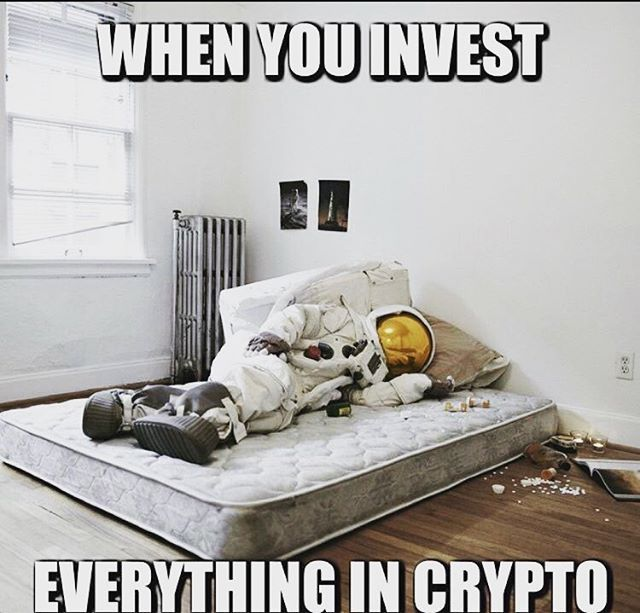

<a href="https://www.reddit.com/r/CryptoCurrency/comments/ltqlz9/what_happens_when_you_invest_in_crypto_you_go_to/">via reddit</a>



## Determining Trend with Time-Series Decomposition

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

periods = [7, 28, 365]
   
asset_id = 1 # Bitcoin
# Visualize
f, ax = plt.subplots(nrows=len(periods), ncols=1, figsize=(12, 12))
for i, p in enumerate(periods):
    decomp = seasonal_decompose(train_daily[('Close',  asset_id)].fillna(0), period=p, model='additive', extrapolate_trend='freq')
    train_daily[(f'Trend_{p}',  asset_id)] = np.where(train_daily[('Close',  asset_id)].isna(), np.NaN, decomp.trend) #decomp.trend
    
    
    sns.lineplot(data=train_daily, x='timestamp', y = ('Close',  asset_id) , ax=ax[i], color='lightgrey');
    sns.lineplot(data=train_daily, x='timestamp', y = (f'Trend_{p}',  asset_id) , ax=ax[i], color='red');
    ax[i].set_title(f"{asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0]} Trend with a Period of {p} Day")
    ax[i].set_xlim([train_daily.timestamp.iloc[0], train_daily.timestamp.iloc[-1]])
    #ax[i].set_ylim([-0.6,0.6])
    ax[i].set_ylabel('Close Price [$]')
    
#plt.suptitle(f'Underlying Trend with {PERIOD} day period\n')
plt.tight_layout()
plt.show()

So, it really depends on what period you look at:
If we look at the 365 day period trend, we are definitely going to the moon. 

## Determining Trend with Moving Average Plot

In [ ]:
trend = train_daily[('Close',  1)].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()   

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

sns.lineplot(data=train_daily, x='timestamp', y = ('Close',  1) , ax=ax, color='lightgrey');
sns.lineplot(x=train_daily['timestamp'], y = trend, ax=ax, color='red');
#ax[i].set_title(f"{asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0]} Trend with a Period of {p} Day")
ax.set_xlim([train_daily.timestamp.iloc[0], train_daily.timestamp.iloc[-1]])
#ax[i].set_ylabel('Close Price [$]')

#plt.suptitle(f'Underlying Trend with {PERIOD} day period\n')
plt.show()

## Altcoin Season

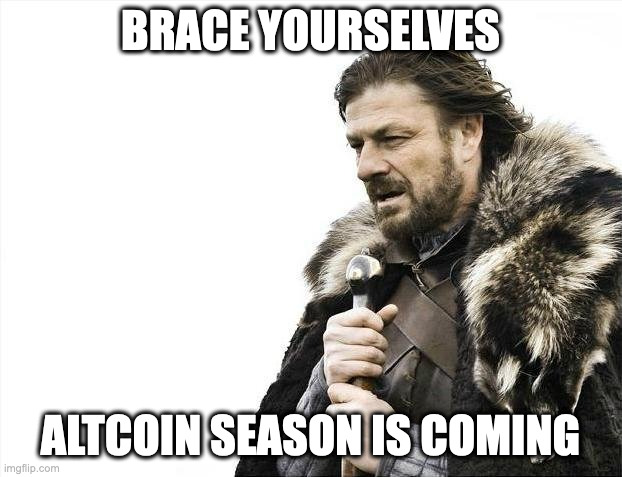

The term *altcoins* refers to all cryptocurrencies other than Bitcoin.

> If 75% of the Top 50 coins performed better than Bitcoin over the last season (90 days) it is Altcoin Season. Excluded from the Top 50 are Stablecoins (Tether, DAI…) and asset backed tokens (WBTC, stETH, cLINK,…) - [Altcoin Season Index on blockchaincenter.net](https://www.blockchaincenter.net/altcoin-season-index/)

# Seasonality

Let's see if we can see any similarity in volatility across several years. E.g. is the volatility always high at the end of the year?

The below plot does not necessarily seem to indicate any seasonal pattern like that on the first glance.

In [ ]:
# Visualize
f, ax = plt.subplots(nrows=len(train_daily.year.unique()), ncols=1, figsize=(12, 12))
for i, year in enumerate(train_daily.year.unique()):

    sns.lineplot(data=train_daily[train_daily.year == year], x='dayofyear', y = ('lret',  1), ax=ax[i])
    sns.lineplot(data=train_daily[train_daily.year == year], x='dayofyear', y = 0 , ax=ax[i], color='black');

    ax[i].set_title(year)
    ax[i].set_xlim([0, 365])
    ax[i].set_ylim([-.2, .2])

plt.tight_layout()
plt.show()

Utility functions from [Learn Tutorial: Time Series, Seasonality by Ryan Holbrook](https://www.kaggle.com/ryanholbrook/seasonality)

In [ ]:
# https://www.kaggle.com/ryanholbrook/seasonality

# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


In [ ]:
X = train_daily[[('Close', 1), ('dayofyear', ''), ('year', '')]]
X.columns = X.columns.get_level_values(0)

seasonal_plot(X, y='Close', period='year', freq='dayofyear');

In [ ]:
X = train_daily[[('Close', 1), ('weekday', ''), ('weekofyear', '')]]
X.columns = X.columns.get_level_values(0)

seasonal_plot(X, y='Close', period='weekofyear', freq='weekday');

In [ ]:
X = train_daily.set_index('timestamp')[('Close', 1)]

plot_periodogram(X);

Neither the seasonal plots nor the periodogram suggest any strong seasonality.

In [ ]:
# Upper Shadow and Lower Shadow as shown in the [Tutorial to the G-Research Crypto Competition](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition)

for i, asset_id in enumerate(asset_details.Asset_ID):
    train_daily[('upper_shadow',  asset_id)] = train_daily[('High',  asset_id)] - np.maximum(train_daily[('Close',  asset_id)], train_daily[('Open',  asset_id)])
    train_daily[('lower_shadow',  asset_id)] = np.minimum(train_daily[('Close',  asset_id)], train_daily[('Open',  asset_id)]) - train_daily[('Low',  asset_id)]
    
asset_id = 1

temp = train_daily[[('Open',  asset_id), ('Low',  asset_id), ('High',  asset_id), ('Close',  asset_id), ('upper_shadow',  asset_id), ('lower_shadow',  asset_id)]]
sns.heatmap(temp.corr(), vmin=0, vmax=1, cmap='Blues', annot=True)
plt.show()

asset_id = 6

temp = train_daily[[('Open',  asset_id), ('Low',  asset_id), ('High',  asset_id), ('Close',  asset_id), ('upper_shadow',  asset_id), ('lower_shadow',  asset_id)]]
sns.heatmap(temp.corr(), vmin=0, vmax=1, cmap='Blues', annot=True)
plt.show()

In [ ]:
## Stationarity

#The 'Close' prices seem to be mostly non-stationary. However, Bitcoin and Ethereum seem to be stationary.

from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, asset_id):
    # Copied and edited from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print(f"{asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0]}: \u001b[32mStationary\u001b[0m")
    else:
        print(f"{asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0]}: \x1b[31mNon-stationary\x1b[0m")
       
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('\n')

assets_mini = [1, 6, 9, 4]
for i, asset_id in enumerate(assets_mini):    
    check_stationarity(train_daily[('Close', i)].fillna(0), asset_id)
    
    
    
# The log returns seem to be stationary.
for i, asset_id in enumerate(assets_mini):    
    check_stationarity(train_daily[('lret', i)].fillna(0), asset_id)

# Other Time Series Forecasting Notebooks

- [Intro to Time Series Forecasting](https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting)
- [Time Series Forecasting: Building Intuition](https://www.kaggle.com/iamleonie/time-series-forecasting-building-intuition)
- [Time Series: Interpreting ACF and PACF](https://www.kaggle.com/iamleonie/time-series-interpreting-acf-and-pacf)
